## Autoencoder for Earthquake triggered ground motion using fourier spectral amplitudes

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import math
from mpl_toolkits.basemap import Basemap


### read and prepare data

In [2]:
data_all = pd.read_csv('ESM_flatfile_FAS.csv',sep = ';', low_memory=False)

Select the columns with Fourier spectral amplitudes and reduce the two horizontal components to one value. Remove records with nan-values.

In [3]:
## get labels of columns with FAS values
FAS_U_labels = [x for x in data_all.columns if 'U_F' in x]
FAS_V_labels = [x for x in data_all.columns if 'V_F' in x]
FAS_W_labels = [x for x in data_all.columns if 'W_F' in x]

## uplod data
M = data_all.Mw.values
Djb = data_all.JB_dist.values
PGA = (abs(data_all.U_pga.values))
Depi = data_all.epi_dist.values

lat = data_all.st_latitude.values
long = data_all.st_longitude.values


## get the values of considered frequencies
frequencies  = [float(x[3:].replace("_", ".")) for x in FAS_U_labels]

## taking root mean squared values of horizontal components
FAS_h = np.sqrt((np.asarray(data_all[FAS_U_labels])**2 + 
                 np.asarray(data_all[FAS_V_labels])**2)/2 )

## data set with horizontal and vertical component
FAS = np.concatenate((FAS_h, np.asarray(data_all[FAS_W_labels])), axis=1)


## remove nan's
nan_rows = list(set(np.where(np.isnan(FAS))[0]))
FAS = np.delete(FAS, nan_rows, 0)
PGA = np.delete(PGA, nan_rows, 0).reshape(-1,1)
Depi = np.delete(Depi, nan_rows, 0).reshape(-1,1)
M = np.delete(M, nan_rows, 0).reshape(-1,1)
lat = np.delete(lat, nan_rows, 0).reshape(-1,1)
long = np.delete(long, nan_rows, 0).reshape(-1,1)


nan_rows = list(set(np.where(np.isnan(M))[0]))
FAS = np.delete(FAS, nan_rows, 0)
PGA = np.delete(PGA, nan_rows, 0).reshape(-1,1)
Depi = np.delete(Depi, nan_rows, 0).reshape(-1,1)
M = np.delete(M, nan_rows, 0).reshape(-1,1)
lat = np.delete(lat, nan_rows, 0).reshape(-1,1)
long = np.delete(long, nan_rows, 0).reshape(-1,1)

nan_rows = list(set(np.where(np.isnan(PGA))[0]))
FAS = np.delete(FAS, nan_rows, 0)
PGA = np.delete(PGA, nan_rows, 0).reshape(-1,1)
Depi = np.delete(Depi, nan_rows, 0).reshape(-1,1)
M = np.delete(M, nan_rows, 0).reshape(-1,1)
lat = np.delete(lat, nan_rows, 0).reshape(-1,1)
long = np.delete(long, nan_rows, 0).reshape(-1,1)

nan_rows = list(set(np.where(np.isnan(Depi))[0]))
FAS = np.delete(FAS, nan_rows, 0)
PGA = np.delete(PGA, nan_rows, 0).reshape(-1,1)
Depi = np.delete(Depi, nan_rows, 0).reshape(-1,1)
M = np.delete(M, nan_rows, 0).reshape(-1,1)
lat = np.delete(lat, nan_rows, 0).reshape(-1,1)
long = np.delete(long, nan_rows, 0).reshape(-1,1)


print("Data set dimension:", FAS.shape)


Data set dimension: (19175, 206)


No handles with labels found to put in legend.


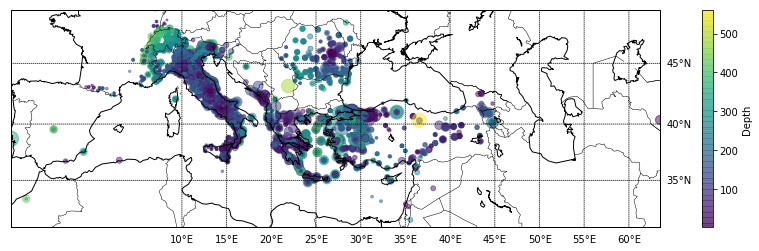

In [4]:
fig, ax = plt.subplots(1, figsize=(15,4))
eq_map = Basemap(projection='merc'
                 ,llcrnrlat=np.min(lat),llcrnrlon=np.min(long)
                 ,urcrnrlat=np.max(lat),urcrnrlon=np.max(long)
                 ,resolution='l', area_thresh=1000.0, ax=ax)

eq_map.drawcoastlines()
eq_map.drawcountries()
#eq_map.fillcontinents()
eq_map.drawmapboundary()

parallels = np.arange(0.,81,5.)
eq_map.drawparallels(parallels,labels=[False,True,True,False])

meridians = np.arange(10.,351.,5.)
eq_map.drawmeridians(meridians,labels=[True,False,False,True])


x,y = eq_map(long, lat)
c = eq_map.scatter(x, y, s = 0.1 * np.exp(M),c = Depi , alpha = .5)
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

fig.colorbar(c,label = "Depth")
plt.show()


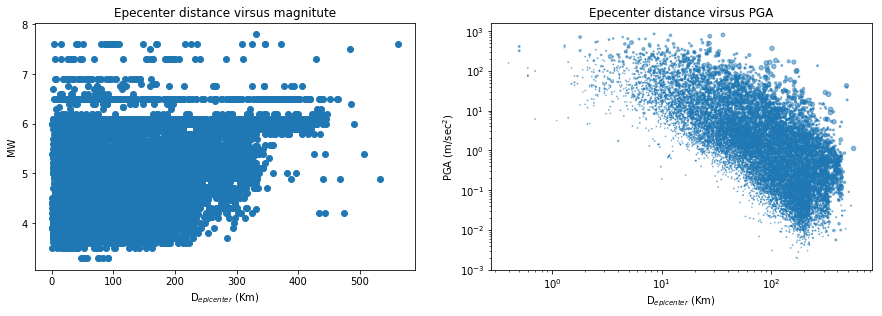

In [5]:
fig = plt.figure(1, figsize=(15, 10))
plt.subplot(221)

plt.scatter(Depi,M)
plt.title('Epecenter distance virsus magnitute')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('MW')

plt.subplot(222)
plt.xscale('log')
plt.yscale('log')
plt.scatter(Depi, PGA,   0.01 * np.exp(M), alpha = .5)

plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


data = np.concatenate((np.log10(PGA) , np.log10(Depi)),axis=1)


#### Define training and test data.
The test and validation set include each about 1/10 of all data. The remaining data are used for training.

In [6]:
batch_size = 128


n_data     = FAS.shape[0]
n_train    = math.ceil(n_data*8/10/batch_size)*batch_size
n_test     = math.ceil((n_data - n_train)/2)
n_val      = n_data - n_train - n_test


eps = 10**(-8)
data_train = np.log10(FAS[ :n_train]+eps)
data_test  = np.log10(FAS[n_train:(n_train+n_test)]+eps)
data_val   = np.log10(FAS[(n_train+n_test):]+eps)


data_train1 = data[ :n_train]
data_test1  = data[n_train:(n_train+n_test)]
data_val1   =  data[(n_train+n_test):]


## shuffle ground motion records in the training data to destroy order,
## e.g. subsequent records of the same earthquake recorded at different stations
np.random.shuffle(data_train1)
np.random.shuffle(data_train)
data_train.shape, data_train1.shape,

((15360, 206), (15360, 2))

Plot frequency spectrum for 10 records for data visualization.

/home/dolatabadi/Program/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


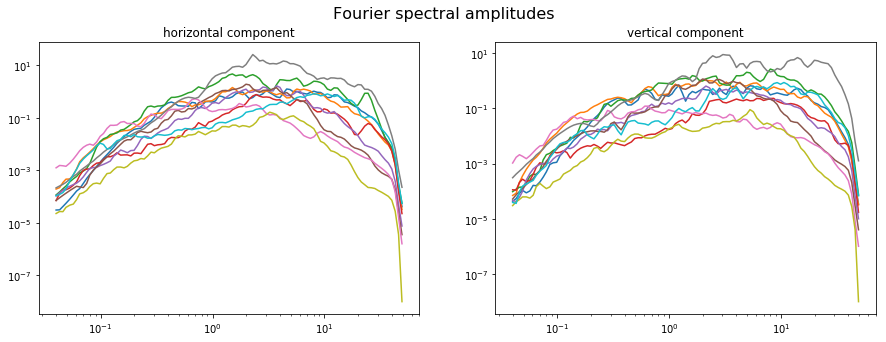

In [7]:
n_freq = len(frequencies)


fig = plt.figure(1, figsize=(15, 5))
fig.suptitle("Fourier spectral amplitudes", fontsize = 16)
for i in range(10):
  plt.subplot(121)
  plt.loglog(frequencies, np.power(10, data_train[i,:n_freq]))
  plt.title("horizontal component")

  plt.subplot(122)
  plt.loglog(frequencies, np.power(10, data_train[i,n_freq:]))
  plt.title("vertical component")
    

plt.show()

In [8]:
## tf data set
# dataset = tf.data.Dataset.from_tensor_slices(np_data)
# dataset = dataset.shuffle(1000).repeat().batch(batch_size)
# next_element = dataset.make_one_shot_iterator().get_next()
# print(next_element)

### Construct Autoencoder For Fourier spectrum!

In [9]:
import os
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()
from functools import partial


In [10]:
reset_graph()

n_inputs  = data_train.shape[1]
n_outputs = n_inputs
n_hidden1 = 128
n_hidden2 = 64 
n_hidden3 = 16
n_hidden4 = 8
n_hidden5 = 4
n_hidden6 = 2

n_hidden2o = n_hidden2
n_hidden1o = n_hidden1


learning_rate = 0.001
l2_reg = 0.0001

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
init = tf.global_variables_initializer()
activation = tf.nn.relu
reg = tf.contrib.layers.l2_regularizer(l2_reg)

my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.relu,
                         kernel_initializer=he_init,
                        kernel_regularizer=reg)

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

def optm(outputs , inputs,learning_rate):
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss] +reg_losses )
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    return training_op , reconstruction_loss

def traing(data_train,data_test,training_op,reconstruction_loss,batch_size):

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        data_shuffle = data_train
        cur_pos = 0 # used to iterate over batches
        for i in range(10001):
            if cur_pos + batch_size > n_train:
                np.random.shuffle(data_shuffle)
                cur_pos = 0            
            sess.run(training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            if i % 1000 == 0:
                train_loss = reconstruction_loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
                test_loss = reconstruction_loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
                print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
            cur_pos += batch_size
        phase1_out_values = outputs.eval(feed_dict = {inputs: data_test})
    return phase1_out_values

# One Hidden layer with different nodes:


In [11]:
print("Phase1")
# Phase 1 One hidden layer with 128 node
hidden11 =  my_dense_layer(inputs, n_hidden1)
outputs = my_dense_layer(hidden11, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p1 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)
        
print("Phase2")
# Phase 1 One hidden layer with 64node
hidden12 =  my_dense_layer(inputs, n_hidden2)
outputs = my_dense_layer(hidden12, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p2 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase3")
# Phase 1 One hidden layer with 16 node
hidden13 =  my_dense_layer(inputs, n_hidden3)
outputs = my_dense_layer(hidden13, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p3 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase4")
# Phase 1 One hidden layer with 8 node
hidden14 =  my_dense_layer(inputs, n_hidden4)
outputs = my_dense_layer(hidden14, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p4 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase5")
# Phase 1 One hidden layer with 4 node
hidden15 =  my_dense_layer(inputs, n_hidden5)
outputs = my_dense_layer(hidden15, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p5 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)


print("Phase6")
# Phase 1 One hidden layer with 2 node
hidden16 =  my_dense_layer(inputs, n_hidden6)
outputs = my_dense_layer(hidden16, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p6 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)



Phase1
step 0: training loss = 11.3108, test loss: 5.70696
step 1000: training loss = 0.0240705, test loss: 0.0260248
step 2000: training loss = 0.0151463, test loss: 0.015385
step 3000: training loss = 0.0104689, test loss: 0.0104839
step 4000: training loss = 0.00817155, test loss: 0.00816463
step 5000: training loss = 0.00711289, test loss: 0.00687644
step 6000: training loss = 0.00687446, test loss: 0.0062399
step 7000: training loss = 0.00549292, test loss: 0.0053801
step 8000: training loss = 0.00497881, test loss: 0.00482645
step 9000: training loss = 0.00470882, test loss: 0.00445324
step 10000: training loss = 0.00470179, test loss: 0.00443056
Phase2
step 0: training loss = 12.3691, test loss: 6.83976
step 1000: training loss = 0.0341731, test loss: 0.0364086
step 2000: training loss = 0.0220844, test loss: 0.0234943
step 3000: training loss = 0.0165747, test loss: 0.0171322
step 4000: training loss = 0.0143774, test loss: 0.0141204
step 5000: training loss = 0.0119348, test l

/home/dolatabadi/Program/Anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


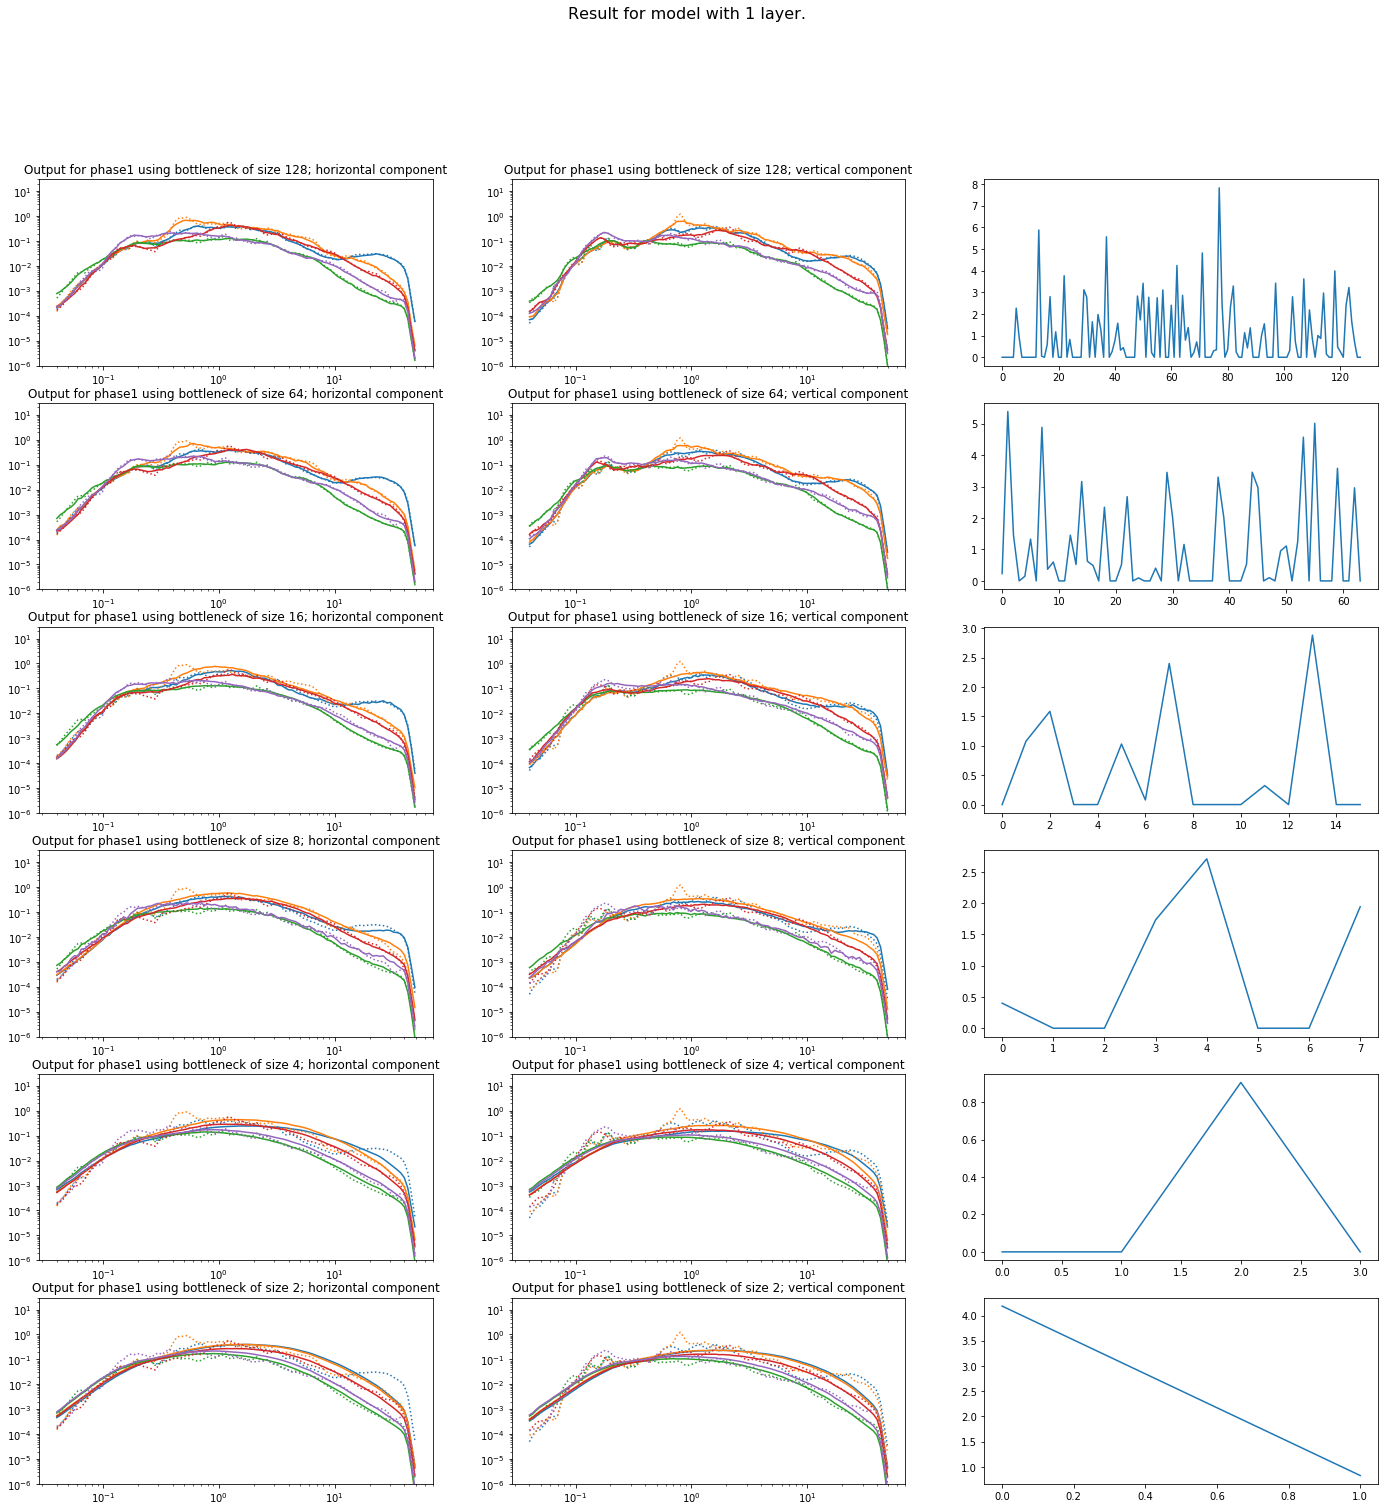

In [12]:
import matplotlib.colors as mcolors
init = tf.global_variables_initializer()

fig = plt.figure(1, figsize=(24, 24))
fig.suptitle("Result for model with 1 layer.", fontsize = 16)
ylim = [10**(-6), 30]
for i in range(5):
    
  plt.subplot(631)
  plt.loglog(frequencies, np.power(10, p1[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden1)
  plt.ylim(ylim)

  plt.subplot(632)
  plt.loglog(frequencies, np.power(10, p1[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden1)
  plt.ylim(ylim)
    
  plt.subplot(634)
  plt.loglog(frequencies, np.power(10, p2[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden2)
  plt.ylim(ylim)

  plt.subplot(635)
  plt.loglog(frequencies, np.power(10, p2[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden2)
  plt.ylim(ylim)

  plt.subplot(637)
  plt.loglog(frequencies, np.power(10, p3[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden3)
  plt.ylim(ylim)

  plt.subplot(638)
  plt.loglog(frequencies, np.power(10, p3[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden3)
  plt.ylim(ylim)

  plt.subplot(6,3,10)
  plt.loglog(frequencies, np.power(10, p4[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden4)
  plt.ylim(ylim)

  plt.subplot(6,3,11)
  plt.loglog(frequencies, np.power(10, p4[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden4)
  plt.ylim(ylim)

  plt.subplot(6,3,13)
  plt.loglog(frequencies, np.power(10, p5[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden5)
  plt.ylim(ylim)

  plt.subplot(6,3,14)
  plt.loglog(frequencies, np.power(10, p5[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden5)
  plt.ylim(ylim)

  plt.subplot(6,3,16)
  plt.loglog(frequencies, np.power(10, p6[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden6)
  plt.ylim(ylim)

  plt.subplot(6,3,17)
  plt.loglog(frequencies, np.power(10, p6[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden6)
  plt.ylim(ylim)



plt.subplot(6,3,3)
with tf.Session() as sess:
    init.run()
    a1 = hidden11.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)

plt.subplot(6,3,6)
with tf.Session() as sess:
    init.run()
    a1 = hidden12.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,9)
with tf.Session() as sess:
    init.run()
    a1 = hidden13.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,12)
with tf.Session() as sess:
    init.run()
    a1 = hidden14.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,15)
with tf.Session() as sess:
    init.run()
    a1 = hidden15.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,18)
with tf.Session() as sess:
    init.run()
    a1 = hidden16.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)

plt.show()



# Two Hidden layer the first 128 node, the second one variable

In [13]:
print("Phase 1 One hidden layer with 64 node in bottleneck")
# Phase 1 One hidden layer with 64 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden11 =  my_dense_layer(hidden1, n_hidden2)
outputs = my_dense_layer(hidden11, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p1 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase 2 One hidden layer with 16 node in bottleneck")
# Phase 1 One hidden layer with 32node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden12 =  my_dense_layer(hidden1, n_hidden3)
outputs = my_dense_layer(hidden12, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p2 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase 3 One hidden layer with 8 node in bottleneck")
# Phase 1 One hidden layer with 16 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden13 =  my_dense_layer(hidden1, n_hidden4)
outputs = my_dense_layer(hidden13, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p3 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase 4 One hidden layer with 4 node in bottleneck")
# Phase 1 One hidden layer with 8 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden14 =  my_dense_layer(hidden1, n_hidden5)
outputs = my_dense_layer(hidden14, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p4 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase 5 One hidden layer with 2 node in bottleneck")
# Phase 1 One hidden layer with 4 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden15 =  my_dense_layer(hidden1, n_hidden6)
outputs = my_dense_layer(hidden15, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p5 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)




Phase 1 One hidden layer with 64 node in bottleneck
step 0: training loss = 10.1676, test loss: 5.98431
step 1000: training loss = 0.0291117, test loss: 0.0314626
step 2000: training loss = 0.0181163, test loss: 0.0197268
step 3000: training loss = 0.0159145, test loss: 0.0158378
step 4000: training loss = 0.0128656, test loss: 0.0131848
step 5000: training loss = 0.0112355, test loss: 0.0110124
step 6000: training loss = 0.00945045, test loss: 0.0101499
step 7000: training loss = 0.00891695, test loss: 0.00922526
step 8000: training loss = 0.0090182, test loss: 0.00839136
step 9000: training loss = 0.00792331, test loss: 0.0080124
step 10000: training loss = 0.00752348, test loss: 0.00752301
Phase 2 One hidden layer with 16 node in bottleneck
step 0: training loss = 10.9402, test loss: 5.98705
step 1000: training loss = 0.29716, test loss: 0.385182
step 2000: training loss = 0.0371712, test loss: 0.0368234
step 3000: training loss = 0.0349702, test loss: 0.035391
step 4000: training l

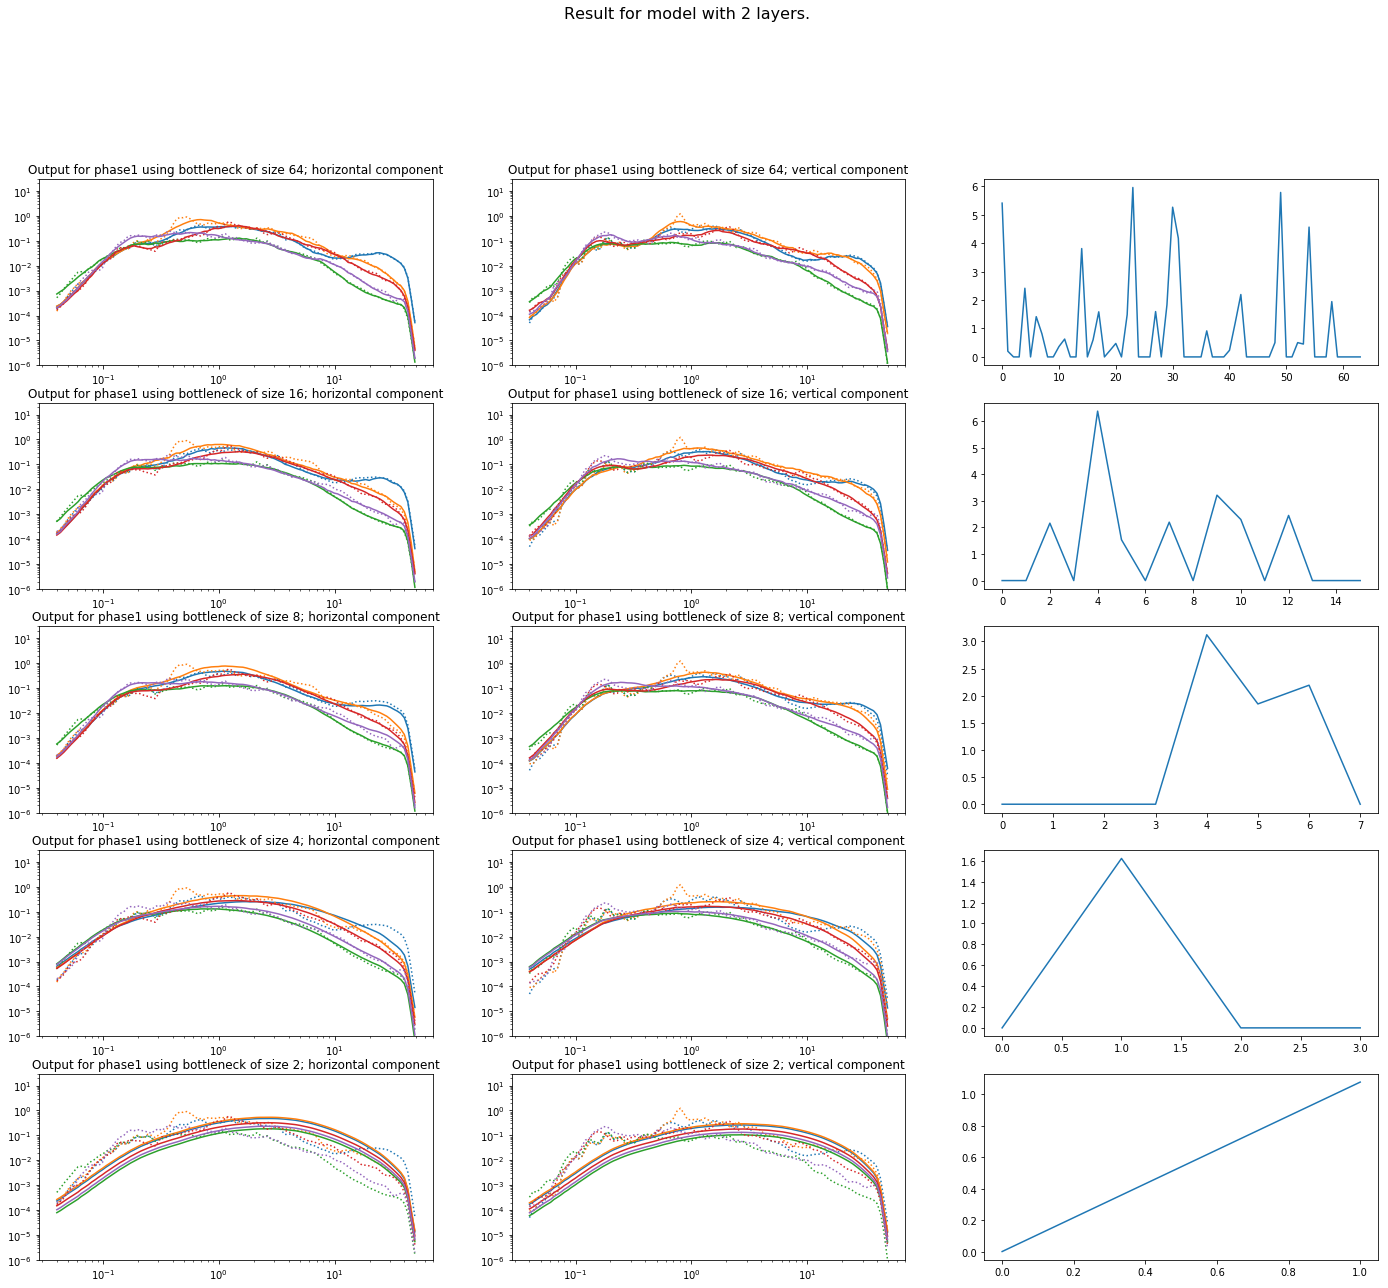

In [15]:
init = tf.global_variables_initializer()

fig = plt.figure(1, figsize=(24, 24))
fig.suptitle("Result for model with 2 layers.", fontsize = 16)
ylim = [10**(-6), 30]
for i in range(5):
    
  plt.subplot(631)
  plt.loglog(frequencies, np.power(10, p1[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden2)
  plt.ylim(ylim)

  plt.subplot(632)
  plt.loglog(frequencies, np.power(10, p1[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden2)
  plt.ylim(ylim)
    
  plt.subplot(634)
  plt.loglog(frequencies, np.power(10, p2[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden3)
  plt.ylim(ylim)

  plt.subplot(635)
  plt.loglog(frequencies, np.power(10, p2[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden3)
  plt.ylim(ylim)

  plt.subplot(637)
  plt.loglog(frequencies, np.power(10, p3[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden4)
  plt.ylim(ylim)

  plt.subplot(638)
  plt.loglog(frequencies, np.power(10, p3[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden4)
  plt.ylim(ylim)

  plt.subplot(6,3,10)
  plt.loglog(frequencies, np.power(10, p4[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden5)
  plt.ylim(ylim)

  plt.subplot(6,3,11)
  plt.loglog(frequencies, np.power(10, p4[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden5)
  plt.ylim(ylim)

  plt.subplot(6,3,13)
  plt.loglog(frequencies, np.power(10, p5[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden6)
  plt.ylim(ylim)

  plt.subplot(6,3,14)
  plt.loglog(frequencies, np.power(10, p5[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden6)
  plt.ylim(ylim)


plt.subplot(6,3,3)
with tf.Session() as sess:
    init.run()
    a1 = hidden11.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)

plt.subplot(6,3,6)
with tf.Session() as sess:
    init.run()
    a1 = hidden12.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,9)
with tf.Session() as sess:
    init.run()
    a1 = hidden13.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,12)
with tf.Session() as sess:
    init.run()
    a1 = hidden14.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,15)
with tf.Session() as sess:
    init.run()
    a1 = hidden15.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)

plt.show()



In [16]:
print("Phase 1 One hidden layer with 16 node in bottleneck")
# Phase 1 One hidden layer with 16 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden2 =  my_dense_layer(hidden1, n_hidden2)
hidden11 =  my_dense_layer(hidden2, n_hidden3)
hidden3 =  my_dense_layer(hidden11, n_hidden2)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p1 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)
        
print("Phase 2 One hidden layer with 8 node in bottleneck")
# Phase 1 One hidden layer with 32node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden2 =  my_dense_layer(hidden1, n_hidden2)
hidden12 =  my_dense_layer(hidden2, n_hidden4)
hidden3 =  my_dense_layer(hidden11, n_hidden2)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p2 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase 3 One hidden layer with 4 node in bottleneck")
# Phase 1 One hidden layer with 16 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden2 =  my_dense_layer(hidden1, n_hidden2)
hidden13 =  my_dense_layer(hidden2, n_hidden5)
hidden3 =  my_dense_layer(hidden11, n_hidden2)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p3 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)

print("Phase 4 One hidden layer with 2 node in bottleneck")
# Phase 1 One hidden layer with 8 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden2 =  my_dense_layer(hidden1, n_hidden2)
hidden14 =  my_dense_layer(hidden2, n_hidden6)
hidden3 =  my_dense_layer(hidden11, n_hidden2)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p4 = traing(data_train,data_test,training_op,reconstruction_loss,batch_size)




Phase 1 One hidden layer with 16 node in bottleneck
step 0: training loss = 5.56889, test loss: 3.1034
step 1000: training loss = 0.0365558, test loss: 0.039904
step 2000: training loss = 0.0290345, test loss: 0.0331414
step 3000: training loss = 0.0292098, test loss: 0.0331389
step 4000: training loss = 0.0257349, test loss: 0.0280309
step 5000: training loss = 0.0268443, test loss: 0.0283153
step 6000: training loss = 0.0250263, test loss: 0.0270692
step 7000: training loss = 0.02053, test loss: 0.023117
step 8000: training loss = 0.0216264, test loss: 0.0226909
step 9000: training loss = 0.0211578, test loss: 0.0226463
step 10000: training loss = 0.0215945, test loss: 0.0235685
Phase 2 One hidden layer with 8 node in bottleneck
step 0: training loss = 6.59899, test loss: 2.98123
step 1000: training loss = 0.0517568, test loss: 0.0550524
step 2000: training loss = 0.0345285, test loss: 0.0382669
step 3000: training loss = 0.0283436, test loss: 0.0333056
step 4000: training loss = 0.0

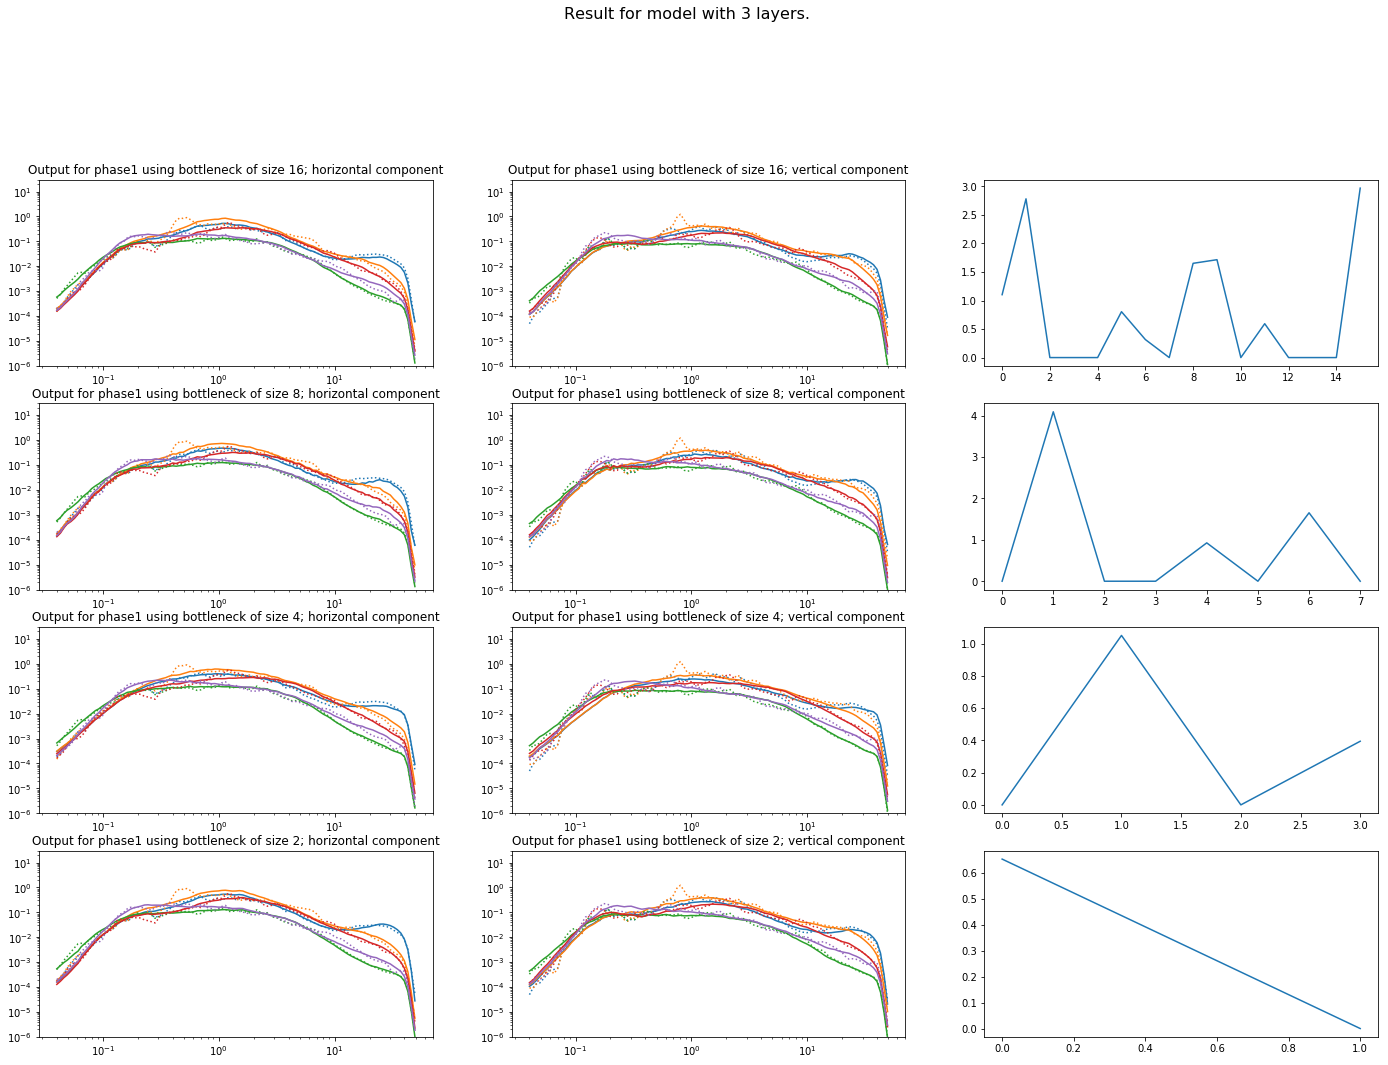

In [17]:
init = tf.global_variables_initializer()

fig = plt.figure(1, figsize=(24, 24))
fig.suptitle("Result for model with 3 layers.", fontsize = 16)
ylim = [10**(-6), 30]
for i in range(5):

  plt.subplot(631)
  plt.loglog(frequencies, np.power(10, p1[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden3)
  plt.ylim(ylim)

  plt.subplot(632)
  plt.loglog(frequencies, np.power(10, p1[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden3)
  plt.ylim(ylim)

  plt.subplot(634)
  plt.loglog(frequencies, np.power(10, p2[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden4)
  plt.ylim(ylim)

  plt.subplot(635)
  plt.loglog(frequencies, np.power(10, p2[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden4)
  plt.ylim(ylim)

  plt.subplot(637)
  plt.loglog(frequencies, np.power(10, p3[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden5)
  plt.ylim(ylim)

  plt.subplot(638)
  plt.loglog(frequencies, np.power(10, p3[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden5)
  plt.ylim(ylim)

  plt.subplot(6,3,10)
  plt.loglog(frequencies, np.power(10, p4[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden6)
  plt.ylim(ylim)

  plt.subplot(6,3,11)
  plt.loglog(frequencies, np.power(10, p4[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden6)
  plt.ylim(ylim)


plt.subplot(6,3,3)
with tf.Session() as sess:
    init.run()
    a1 = hidden11.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)

plt.subplot(6,3,6)
with tf.Session() as sess:
    init.run()
    a1 = hidden12.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,9)
with tf.Session() as sess:
    init.run()
    a1 = hidden13.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)
plt.subplot(6,3,12)
with tf.Session() as sess:
    init.run()
    a1 = hidden14.eval(feed_dict = {inputs: data_test})
plt.plot(a1[1,:].T)

plt.show()


# Construct Autoencoder For PGA virsus distance

In [18]:
reset_graph()

n_inputs  = data_train1.shape[1]
n_outputs = n_inputs
n_hidden1 = 128
n_hidden2 = 64 
n_hidden3 = 16
n_hidden4 = 8
n_hidden5 = 4
n_hidden6 = 2

n_hidden2o = n_hidden2
n_hidden1o = n_hidden1


learning_rate = 0.001
l2_reg = 0.0001

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
init = tf.global_variables_initializer()
activation = tf.nn.relu
reg = tf.contrib.layers.l2_regularizer(l2_reg)

my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.relu,
                         kernel_initializer=he_init,
                        kernel_regularizer=reg)

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])



In [19]:
print("Phase 1 One hidden layer with 64 node in bottleneck")
# Phase 1 One hidden layer with 64 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden11 =  my_dense_layer(hidden1, n_hidden2)
outputs = my_dense_layer(hidden11, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p1 = traing(data_train1,data_test1,training_op,reconstruction_loss,batch_size)
        
print("Phase 2 One hidden layer with 16 node in bottleneck")
# Phase 1 One hidden layer with 32node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden12 =  my_dense_layer(hidden1, n_hidden3)
outputs = my_dense_layer(hidden12, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p2 = traing(data_train1,data_test1,training_op,reconstruction_loss,batch_size)

print("Phase 3 One hidden layer with 8 node in bottleneck")
# Phase 1 One hidden layer with 16 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden13 =  my_dense_layer(hidden1, n_hidden4)
outputs = my_dense_layer(hidden13, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p3 = traing(data_train1,data_test1,training_op,reconstruction_loss,batch_size)

print("Phase 4 One hidden layer with 4 node in bottleneck")
# Phase 1 One hidden layer with 8 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden14 =  my_dense_layer(hidden1, n_hidden5)
outputs = my_dense_layer(hidden14, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p4 = traing(data_train1,data_test1,training_op,reconstruction_loss,batch_size)

print("Phase 5 One hidden layer with 2 node in bottleneck")
# Phase 1 One hidden layer with 4 node
hidden1 =  my_dense_layer(inputs, n_hidden1)
hidden15 =  my_dense_layer(hidden1, n_hidden6)
outputs = my_dense_layer(hidden15, n_outputs, activation=None)
training_op , reconstruction_loss  = optm(outputs , inputs,learning_rate)
p5 = traing(data_train1,data_test1,training_op,reconstruction_loss,batch_size)



Phase 1 One hidden layer with 64 node in bottleneck
step 0: training loss = 8.68361, test loss: 11.5603
step 1000: training loss = 3.24027e-05, test loss: 3.0714e-05
step 2000: training loss = 1.51971e-05, test loss: 2.08606e-05
step 3000: training loss = 1.55583e-05, test loss: 1.2402e-05
step 4000: training loss = 1.63191e-05, test loss: 1.13745e-05
step 5000: training loss = 8.77538e-06, test loss: 1.09301e-05
step 6000: training loss = 0.000224322, test loss: 0.000177427
step 7000: training loss = 3.06208e-05, test loss: 3.31071e-05
step 8000: training loss = 8.72294e-06, test loss: 1.0731e-05
step 9000: training loss = 1.38445e-05, test loss: 1.5802e-05
step 10000: training loss = 8.00103e-05, test loss: 8.08515e-06
Phase 2 One hidden layer with 16 node in bottleneck
step 0: training loss = 6.71898, test loss: 6.43206
step 1000: training loss = 0.000186549, test loss: 0.000217132
step 2000: training loss = 6.69597e-05, test loss: 6.4645e-05
step 3000: training loss = 3.42674e-05, 

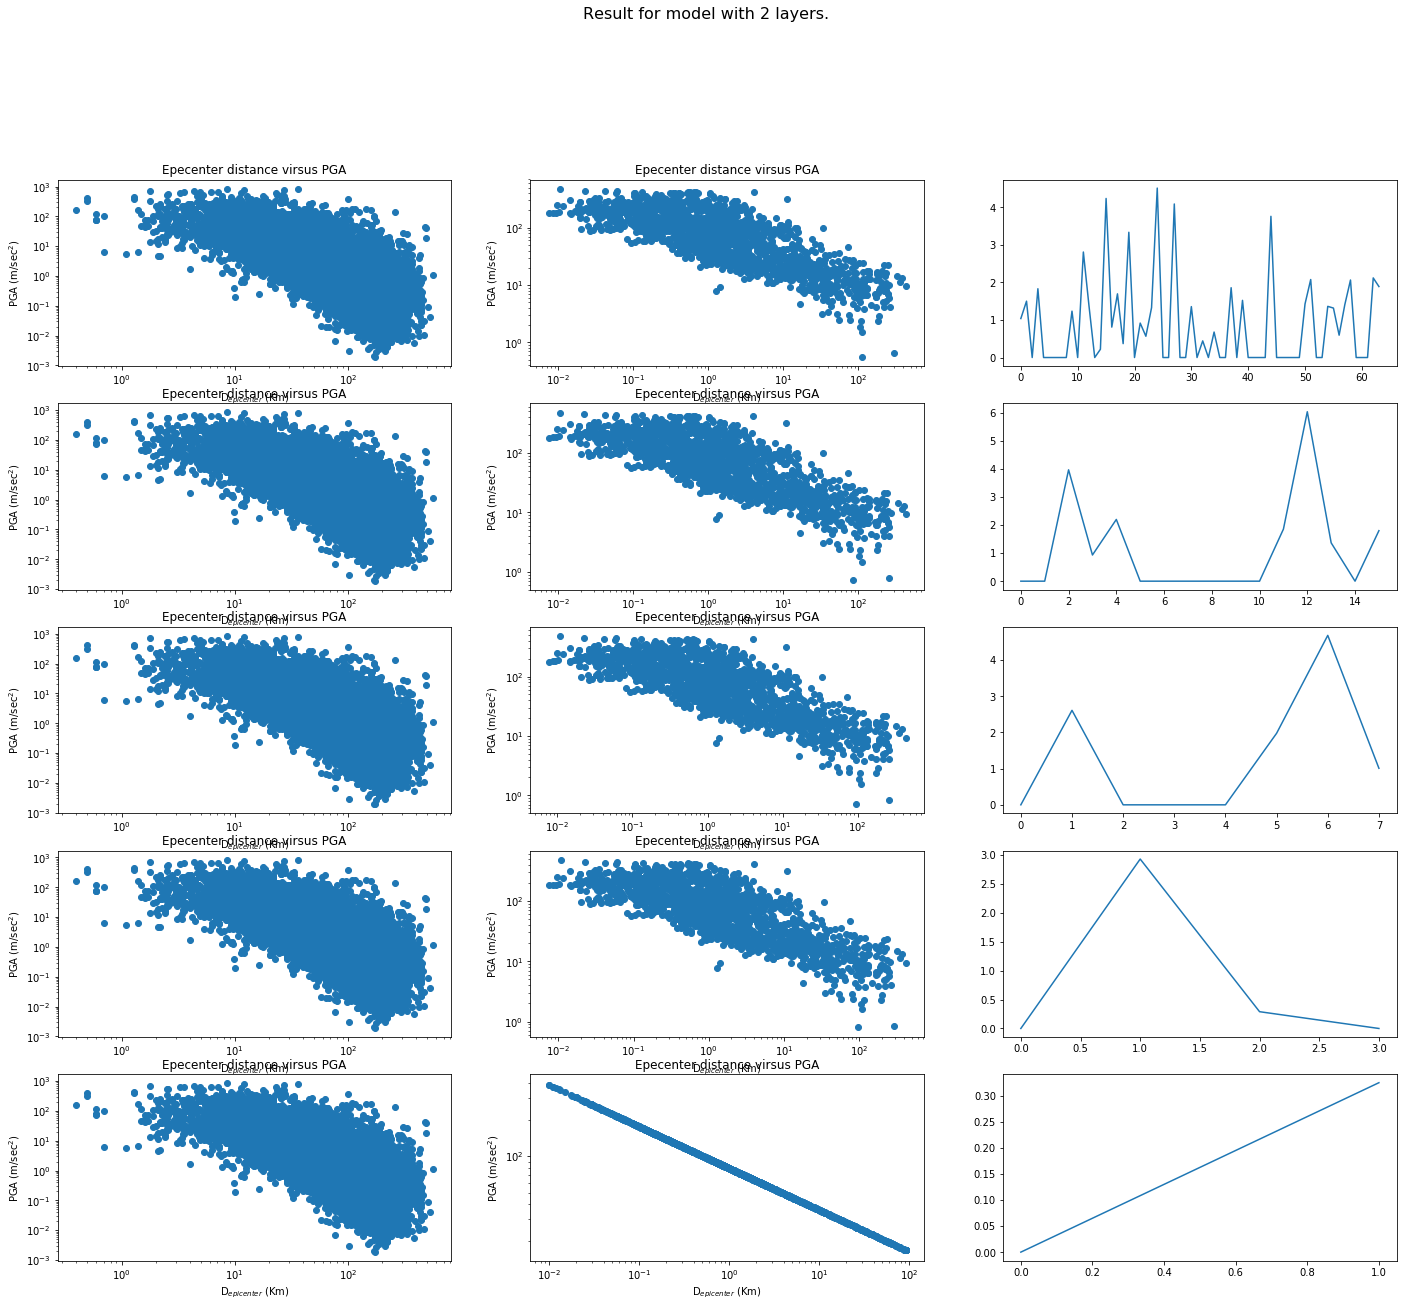

In [20]:
init = tf.global_variables_initializer()

fig = plt.figure(1, figsize=(24, 24))
fig.suptitle("Result for model with 2 layers.", fontsize = 16)
ylim = [10**(-6), 30]
    
plt.subplot(631)
plt.xscale('log')
plt.yscale('log')
plt.scatter(Depi, PGA)
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


plt.subplot(632)
plt.xscale('log')
plt.yscale('log')
plt.scatter(np.power(10,p1[:,0]),np.power(10,p1[:,1]))
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


plt.subplot(634)
plt.xscale('log')
plt.yscale('log')
plt.scatter(Depi, PGA)
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


plt.subplot(635)
plt.xscale('log')
plt.yscale('log')
plt.scatter(np.power(10,p2[:,0]),np.power(10,p2[:,1]))
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')

plt.subplot(637)
plt.xscale('log')
plt.yscale('log')
plt.scatter(Depi, PGA)
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


plt.subplot(638)
plt.xscale('log')
plt.yscale('log')
plt.scatter(np.power(10,p3[:,0]),np.power(10,p3[:,1]))
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')

plt.subplot(6,3,10)
plt.xscale('log')
plt.yscale('log')
plt.scatter(Depi, PGA)
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


plt.subplot(6,3,11)
plt.xscale('log')
plt.yscale('log')
plt.scatter(np.power(10,p4[:,0]),np.power(10,p4[:,1]))
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')

plt.subplot(6,3,13)
plt.xscale('log')
plt.yscale('log')
plt.scatter(Depi, PGA)
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


plt.subplot(6,3,14)
plt.xscale('log')
plt.yscale('log')
plt.scatter(np.power(10,p5[:,0]),np.power(10,p5[:,1]))
plt.title('Epecenter distance virsus PGA')
plt.xlabel('D$_{epicenter}$ (Km)')
plt.ylabel('PGA (m/sec$^{2}$)')


plt.subplot(6,3,3)
with tf.Session() as sess:
    init.run()
    a1 = hidden11.eval(feed_dict = {inputs: data_test1})
plt.plot(a1[1,:].T)

plt.subplot(6,3,6)
with tf.Session() as sess:
    init.run()
    a1 = hidden12.eval(feed_dict = {inputs: data_test1})
plt.plot(a1[1,:].T)
plt.subplot(6,3,9)
with tf.Session() as sess:
    init.run()
    a1 = hidden13.eval(feed_dict = {inputs: data_test1})
plt.plot(a1[1,:].T)
plt.subplot(6,3,12)
with tf.Session() as sess:
    init.run()
    a1 = hidden14.eval(feed_dict = {inputs: data_test1})
plt.plot(a1[1,:].T)
plt.subplot(6,3,15)
with tf.Session() as sess:
    init.run()
    a1 = hidden15.eval(feed_dict = {inputs: data_test1})
plt.plot(a1[1,:].T)

plt.show()